# Machine Learning with PyTorch and Scikit-Learn  

## Chapter 7 - Combining Different Models for Ensemble Learning

Modules requirimet

In [17]:
d = {
    'numpy': '1.21.2',
    'scipy': '1.7.0',
    'matplotlib': '3.4.3',
    'sklearn': '1.0',
    'pandas': '1.3.2',
    'xgboost': '1.5.0',
}

# Learning with ensembles (“Unity is strength”)

> The goal of ensemble methods is to combine different classifiers into a meta-classifier that has better generalization performance than each individual classifier alone.

### Why Ensemble methods?

> Most widely used non-DL model 

- DL is more tricky, deal with model convergence and expensive computationally

[XGBoost Algorithm: Long May She Reign!](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)


![](2022-10-01-12-30-58.png)

Another good read: [Ensemble methods: bagging, boosting and stacking](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205)


![](2022-10-01-12-34-17.png)

- In ensemble learning theory, we call weak learners (or base models) models that can be used as building blocks for designing more complex models by combining several of them. 

- Most of the time, these basics models perform not so well by themselves either because they have a high bias (low degree of freedom models, for example) or because they have too much variance to be robust (high degree of freedom models, for example). 

- Then, the idea of ensemble methods is to try reducing bias and/or variance of such weak learners by combining several of them together in order to create a strong learner (or ensemble model) that achieves better performances.


## Majority Voting

- Assuming that we collected predictions from 10 experts, ensemble methods would allow us to strategically combine those predictions by the 10 experts to come up with a prediction that was more accurate and robust than the predictions by each individual expert.

- There are several different approaches for creating an ensemble of classifiers. 

- Majority voting simply means that we select the class label that has been predicted by the majority of classifiers, that is, received more than 50 percent of the votes. 


![](figures/07_01.png)

> Majority: most frequent label

- Depending on the technique, the ensemble can be built from different classification algorithms, for example, decision trees, support vector machines, logistic regression classifiers, and so on. 
  
- Alternatively, we can also use the same base classification algorithm, fitting different subsets of the training dataset. 

- To predict a class label via simple majority or plurality voting, we can combine the predicted class labels of each individual classifier, Cj

![](2022-10-01-12-07-51.png)

# Combining classifiers via majority vote

## Implementing a simple majority vote classifier 

In [18]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='classlabel')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        y : array-like, shape = [n_examples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError(f"vote must be 'probability' or 'classlabel'"
                             f"; got (vote={self.vote})")

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError(f'Number of classifiers and weights must be equal'
                             f'; got {len(self.weights)} weights,'
                             f' {len(self.classifiers)} classifiers')

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Matrix of training examples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_examples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_examples, n_features]
            Training vectors, where n_examples is the number of examples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_examples, n_classes]
            Weighted average probability for each class per example.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super().get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in self.named_classifiers.items():
                for key, value in step.get_params(deep=True).items():
                    out[f'{name}__{key}'] = value
            return out

Voting classifier is implemented in Sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html


## Using the majority voting principle to make predictions

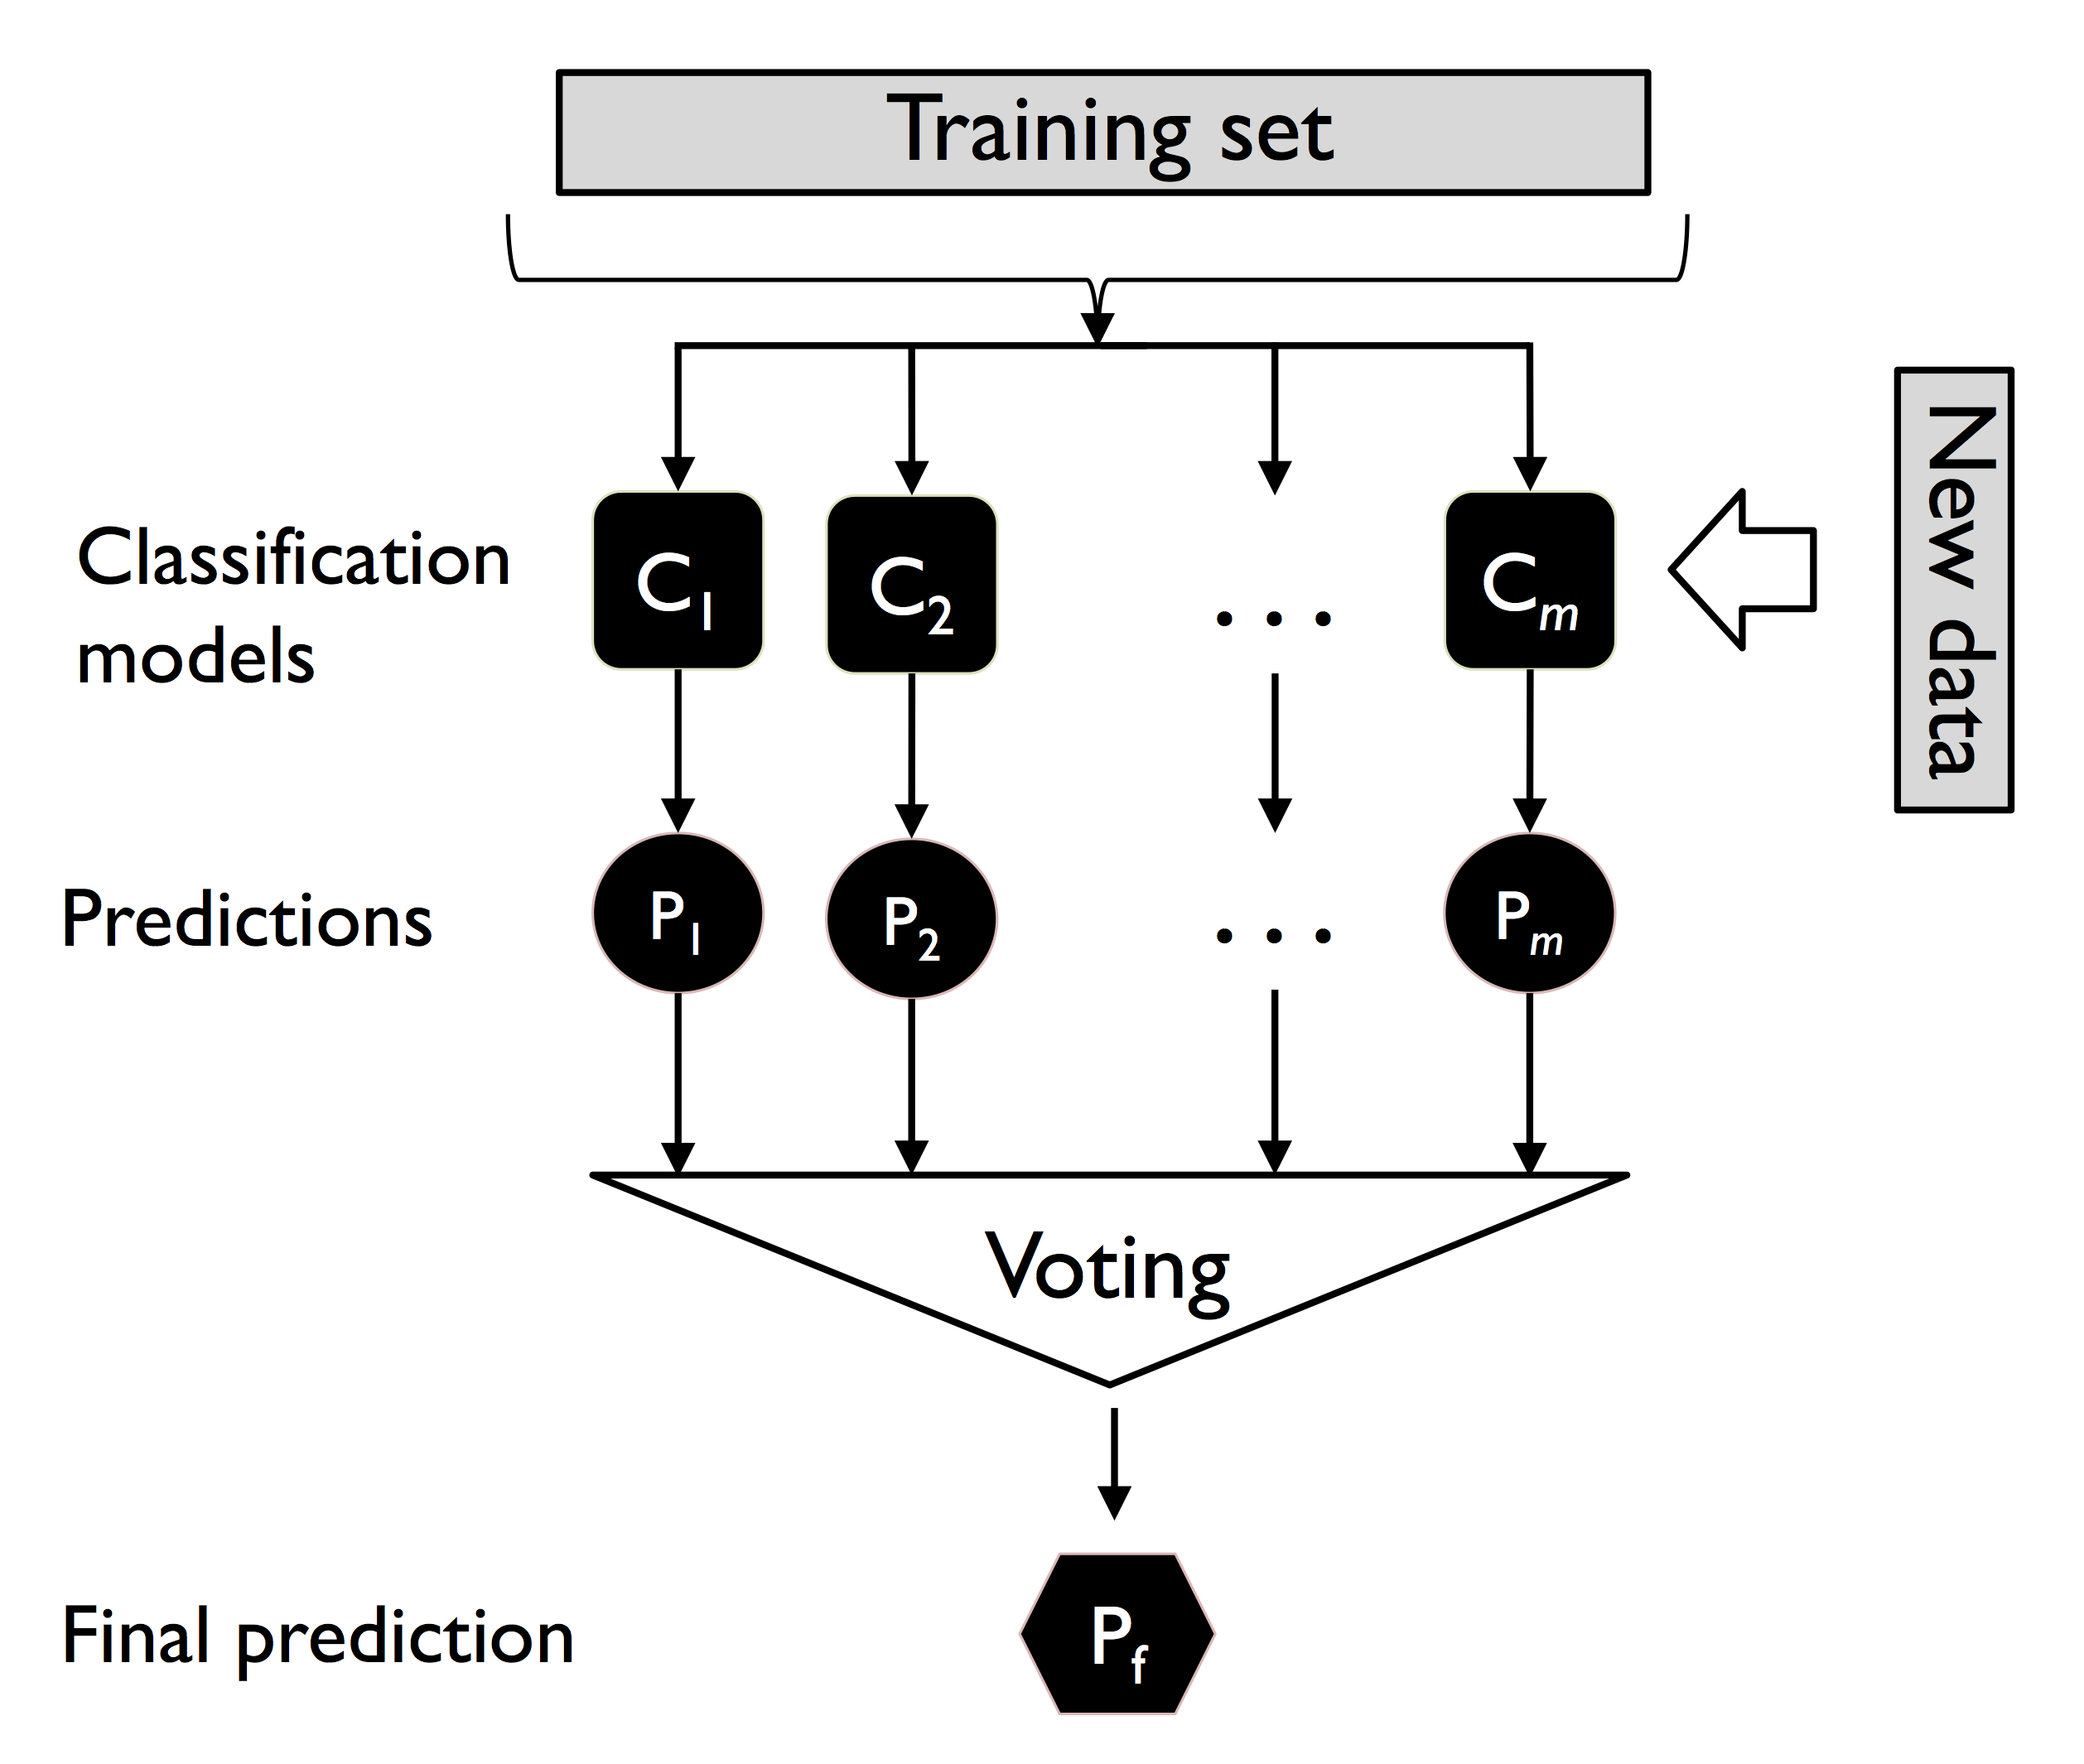

In [19]:
from IPython.display import Image
Image(filename='figures/07_02.png', width=500) 

## Hard Voting

![](2022-10-15-13-14-49.png)

## Soft Voting

![](2022-10-15-13-15-02.png)

In [20]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:] # only two features

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1,
                        stratify=y)

In [21]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

#Both LogisticRegression and KNN are not scale invariant,so we scale them 
#DecisionTree is scale invariant

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')

for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')


10-fold cross validation:

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]


> The output above shows the predictive performances of the individual classifier

Now, let’s move on to the more exciting part and combine the individual classifiers for majority rule voting in our MajorityVoteClassifier:

In [22]:
# Majority Rule (hard) Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels = clf_labels + ['Majority voting'] # new label

all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} '
          f'(+/- {scores.std():.2f}) [{label}]')

ROC AUC: 0.92 (+/- 0.15) [Logistic regression]
ROC AUC: 0.87 (+/- 0.18) [Decision tree]
ROC AUC: 0.85 (+/- 0.13) [KNN]
ROC AUC: 0.98 (+/- 0.05) [Majority voting]


In [23]:
all_clf

[Pipeline(steps=[['sc', StandardScaler()],
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 Pipeline(steps=[['sc', StandardScaler()],
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 MajorityVoteClassifier(classifiers=[Pipeline(steps=[['sc', StandardScaler()],
                                                     ['clf',
                                                      LogisticRegression(C=0.001,
                                                                         random_state=1)]]),
                                     DecisionTreeClassifier(criterion='entropy',
                                                            max_depth=1,
                                                            random_state=0),
                                     Pipeline(steps=[['sc', StandardScaler()],
                                                     ['clf',
               

> As you can see, the performance of MajorityVotingClassifier has improved over the individual classifiers in the 10-fold cross-validation evaluation

## Practice : Voting Classifier


- Hard and Soft Voting Classifier
- Here : https://www.kaggle.com/code/saurabhshahane/voting-classifier

# Evaluating and tuning the ensemble classifier

> Receiver operating characteristic (ROC) graphs are useful tools to select models for classification based on their performance with respect to the FPR and TPR, which are computed by shifting the decision threshold of the classifier. 
  
- The diagonal of a ROC graph can be interpreted as random guessing, and classification models that fall below the diagonal are considered as worse than random guessing. 

> A perfect classifier would fall into the top-left corner of the graph with a TPR of 1 and an FPR of 0. Based on the ROC curve, we can then compute the so-called ROC area under the curve (ROC AUC) to characterize the performance of a classification model.

- We are going to compute the ROC curves from the test dataset to check that MajorityVoteClassifier generalizes well with unseen data. 

- We must remember that the test dataset is not to be used for model selection; its purpose is merely to report an unbiased estimate of the generalization performance of a classifier system:

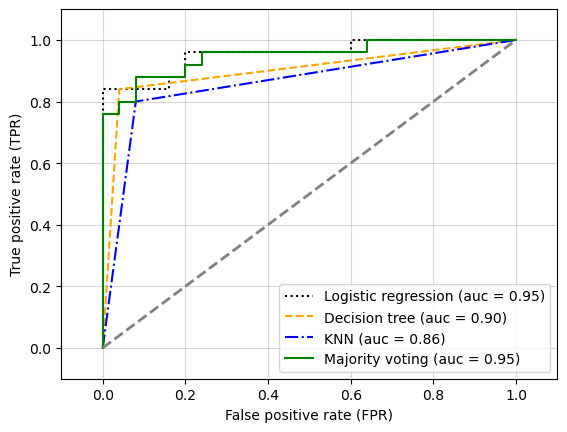

In [24]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label=f'{label} (auc = {roc_auc:.2f})')

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')


#plt.savefig('figures/07_04', dpi=300)
plt.show()

> Reporting the performance of a classifier as the ROC AUC can yield further insights into a classifier’s performance with respect to imbalanced samples.

- Since we only selected two features for the classification examples, it would be interesting to see what the decision region of the ensemble classifier actually looks like.

- Although it is not necessary to standardize the training features prior to model fitting, because our logistic regression and k-nearest neighbors pipelines will automatically take care of it, we will standardize the training dataset so that the decision regions of the decision tree will be on the same scale for visual purposes.

In [25]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)

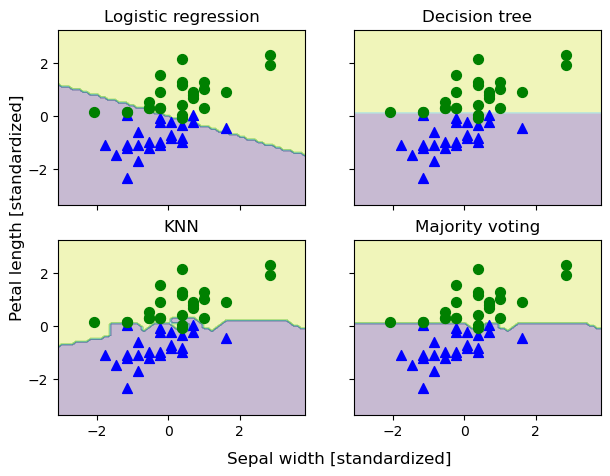

In [26]:
from itertools import product


all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, y_train)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==0, 0], 
                                  X_train_std[y_train==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[y_train==1, 0], 
                                  X_train_std[y_train==1, 1], 
                                  c='green', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -5., 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-12.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

#plt.savefig('figures/07_05', dpi=300)
plt.show()

#### Tuning the model

In [27]:
mv_clf.get_params()

{'pipeline-1': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', LogisticRegression(C=0.001, random_state=1)]]),
 'decisiontreeclassifier': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=0),
 'pipeline-2': Pipeline(steps=[('sc', StandardScaler()),
                 ['clf', KNeighborsClassifier(n_neighbors=1)]]),
 'pipeline-1__memory': None,
 'pipeline-1__steps': [('sc', StandardScaler()),
  ['clf', LogisticRegression(C=0.001, random_state=1)]],
 'pipeline-1__verbose': False,
 'pipeline-1__sc': StandardScaler(),
 'pipeline-1__clf': LogisticRegression(C=0.001, random_state=1),
 'pipeline-1__sc__copy': True,
 'pipeline-1__sc__with_mean': True,
 'pipeline-1__sc__with_std': True,
 'pipeline-1__clf__C': 0.001,
 'pipeline-1__clf__class_weight': None,
 'pipeline-1__clf__dual': False,
 'pipeline-1__clf__fit_intercept': True,
 'pipeline-1__clf__intercept_scaling': 1,
 'pipeline-1__clf__l1_ratio': None,
 'pipeline-1__clf__max_iter': 100,
 'pipeline-1__clf__m

- Based on the values returned by the get_params method, we now know how to access the individual classifier’s attributes. 

- Let’s now tune the inverse regularization parameter, C, of the logistic regression classifier and the decision tree depth via a grid search for demonstration purposes:

Note: logistic regression and the decision tree performs better.

In [28]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [1, 2],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            LogisticRegression(C=0.001,
                                                                                               random_state=1)]]),
                                                           DecisionTreeClassifier(criterion='entropy',
                                                                                  max_depth=1,
                                                                                  random_state=0),
                                                           Pipeline(steps=[('sc',
                                                                            StandardScaler()),
                                                                           ['clf',
                                                                            KNeighborsClassifier(n_neighbors=1)]])]),
             param_grid={'decisiontreeclassifier__max_depth': [1, 2],
                         'pipeline-1__clf__C': [0.001, 0.1, 100.0]},
             scoring='roc_auc')

After the grid search has completed, we can print the different hyperparameter value combinations and the average ROC AUC scores computed via 10-fold cross-validation as follows:

In [29]:
grid.cv_results_

{'mean_fit_time': array([0.00185499, 0.00161645, 0.00173888, 0.0016289 , 0.00149374,
        0.001808  ]),
 'std_fit_time': array([3.77025604e-04, 1.17221687e-04, 1.08997830e-04, 1.08179495e-04,
        7.16244332e-05, 1.20979049e-04]),
 'mean_score_time': array([0.00065489, 0.00060794, 0.00059063, 0.00057635, 0.00056524,
        0.00061536]),
 'std_score_time': array([9.41934327e-05, 7.14562756e-05, 8.74638192e-05, 4.46522037e-05,
        5.87544652e-05, 9.90610691e-05]),
 'param_decisiontreeclassifier__max_depth': masked_array(data=[1, 1, 1, 2, 2, 2],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_pipeline-1__clf__C': masked_array(data=[0.001, 0.1, 100.0, 0.001, 0.1, 100.0],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'decisiontreeclassifier__max_depth': 1,
   'pipeline-1__clf__C': 0.001},
  {'decisiontreeclassifier__max_depth

In [30]:
for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    mean_score = grid.cv_results_['mean_test_score'][r]
    std_dev = grid.cv_results_['std_test_score'][r]
    params = grid.cv_results_['params'][r]
    print(f'{mean_score:.3f} +/- {std_dev:.2f} {params}')

0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 100.0}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.001}
0.983 +/- 0.05 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 0.1}
0.967 +/- 0.10 {'decisiontreeclassifier__max_depth': 2, 'pipeline-1__clf__C': 100.0}


In [31]:
print(f'Best parameters: {grid.best_params_}')
print(f'ROC AUC: {grid.best_score_:.2f}')

Best parameters: {'decisiontreeclassifier__max_depth': 1, 'pipeline-1__clf__C': 0.001}
ROC AUC: 0.98


**Note** 
 
By default, the default setting for `refit` in `GridSearchCV` is `True` (i.e., `GridSeachCV(..., refit=True)`), which means that we can use the fitted `GridSearchCV` estimator to make predictions via the `predict` method, for example:


> To remind ourselves that it is a bad practice to use the test dataset more than once for model evaluation, we are not going to estimate the generalization performance of the tuned hyperparameters in this section. We will move on swiftly to an alternative approach for ensemble learning: bagging.

## Stacking

> Stacking is one of the popular ensemble modeling techniques in machine learning. Various weak learners are ensembled in a parallel manner in such a way that by combining them with Meta learners, we can predict better predictions for the future.


The stacking algorithm can be understood as a two-level ensemble, where the first level consists of individual classifiers that feed their predictions to the second level, where another classifier (typically logistic regression) is fit to the level-one classifier predictions to make the final predictions

![](2022-10-15-11-48-20.png)

![](2022-10-15-11-51-55.png)

Let us see example : Random Forest Classification

In [32]:
### Random Forest Classification

from sklearn.metrics import f1_score, accuracy_score, recall_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.datasets import load_iris

# %%
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
     X, y, stratify=y, random_state=42
)

ss = StandardScaler()
scalled_x_train = ss.fit_transform(X_train)
scalled_x_test = ss.transform(X_test)
# %%
classifier = RandomForestClassifier(
    n_estimators=45, criterion='entropy', n_jobs=-1).fit(scalled_x_train, y_train)

classifier.fit(X_train, y_train).score(X_test, y_test)

0.92

Using Stacking

In [33]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

X, y = load_iris(return_X_y=True)

estimators = [
     ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
     ('svr', make_pipeline(StandardScaler(), LinearSVC(random_state=42)))
        ]

clf = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression()
 )

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
     X, y, stratify=y, random_state=42
)


clf.fit(X_train, y_train).score(X_test, y_test)

0.9473684210526315

# Bagging -- Building an ensemble of classifiers from bootstrap samples

- Bagging is an ensemble learning technique that is closely related to the MajorityVoteClassifier that we implemented in the previous section. 

- However, instead of using the same training dataset to fit the individual classifiers in the ensemble, we draw bootstrap samples (random samples with replacement) from the initial training dataset, which is why bagging is also known as bootstrap aggregating.

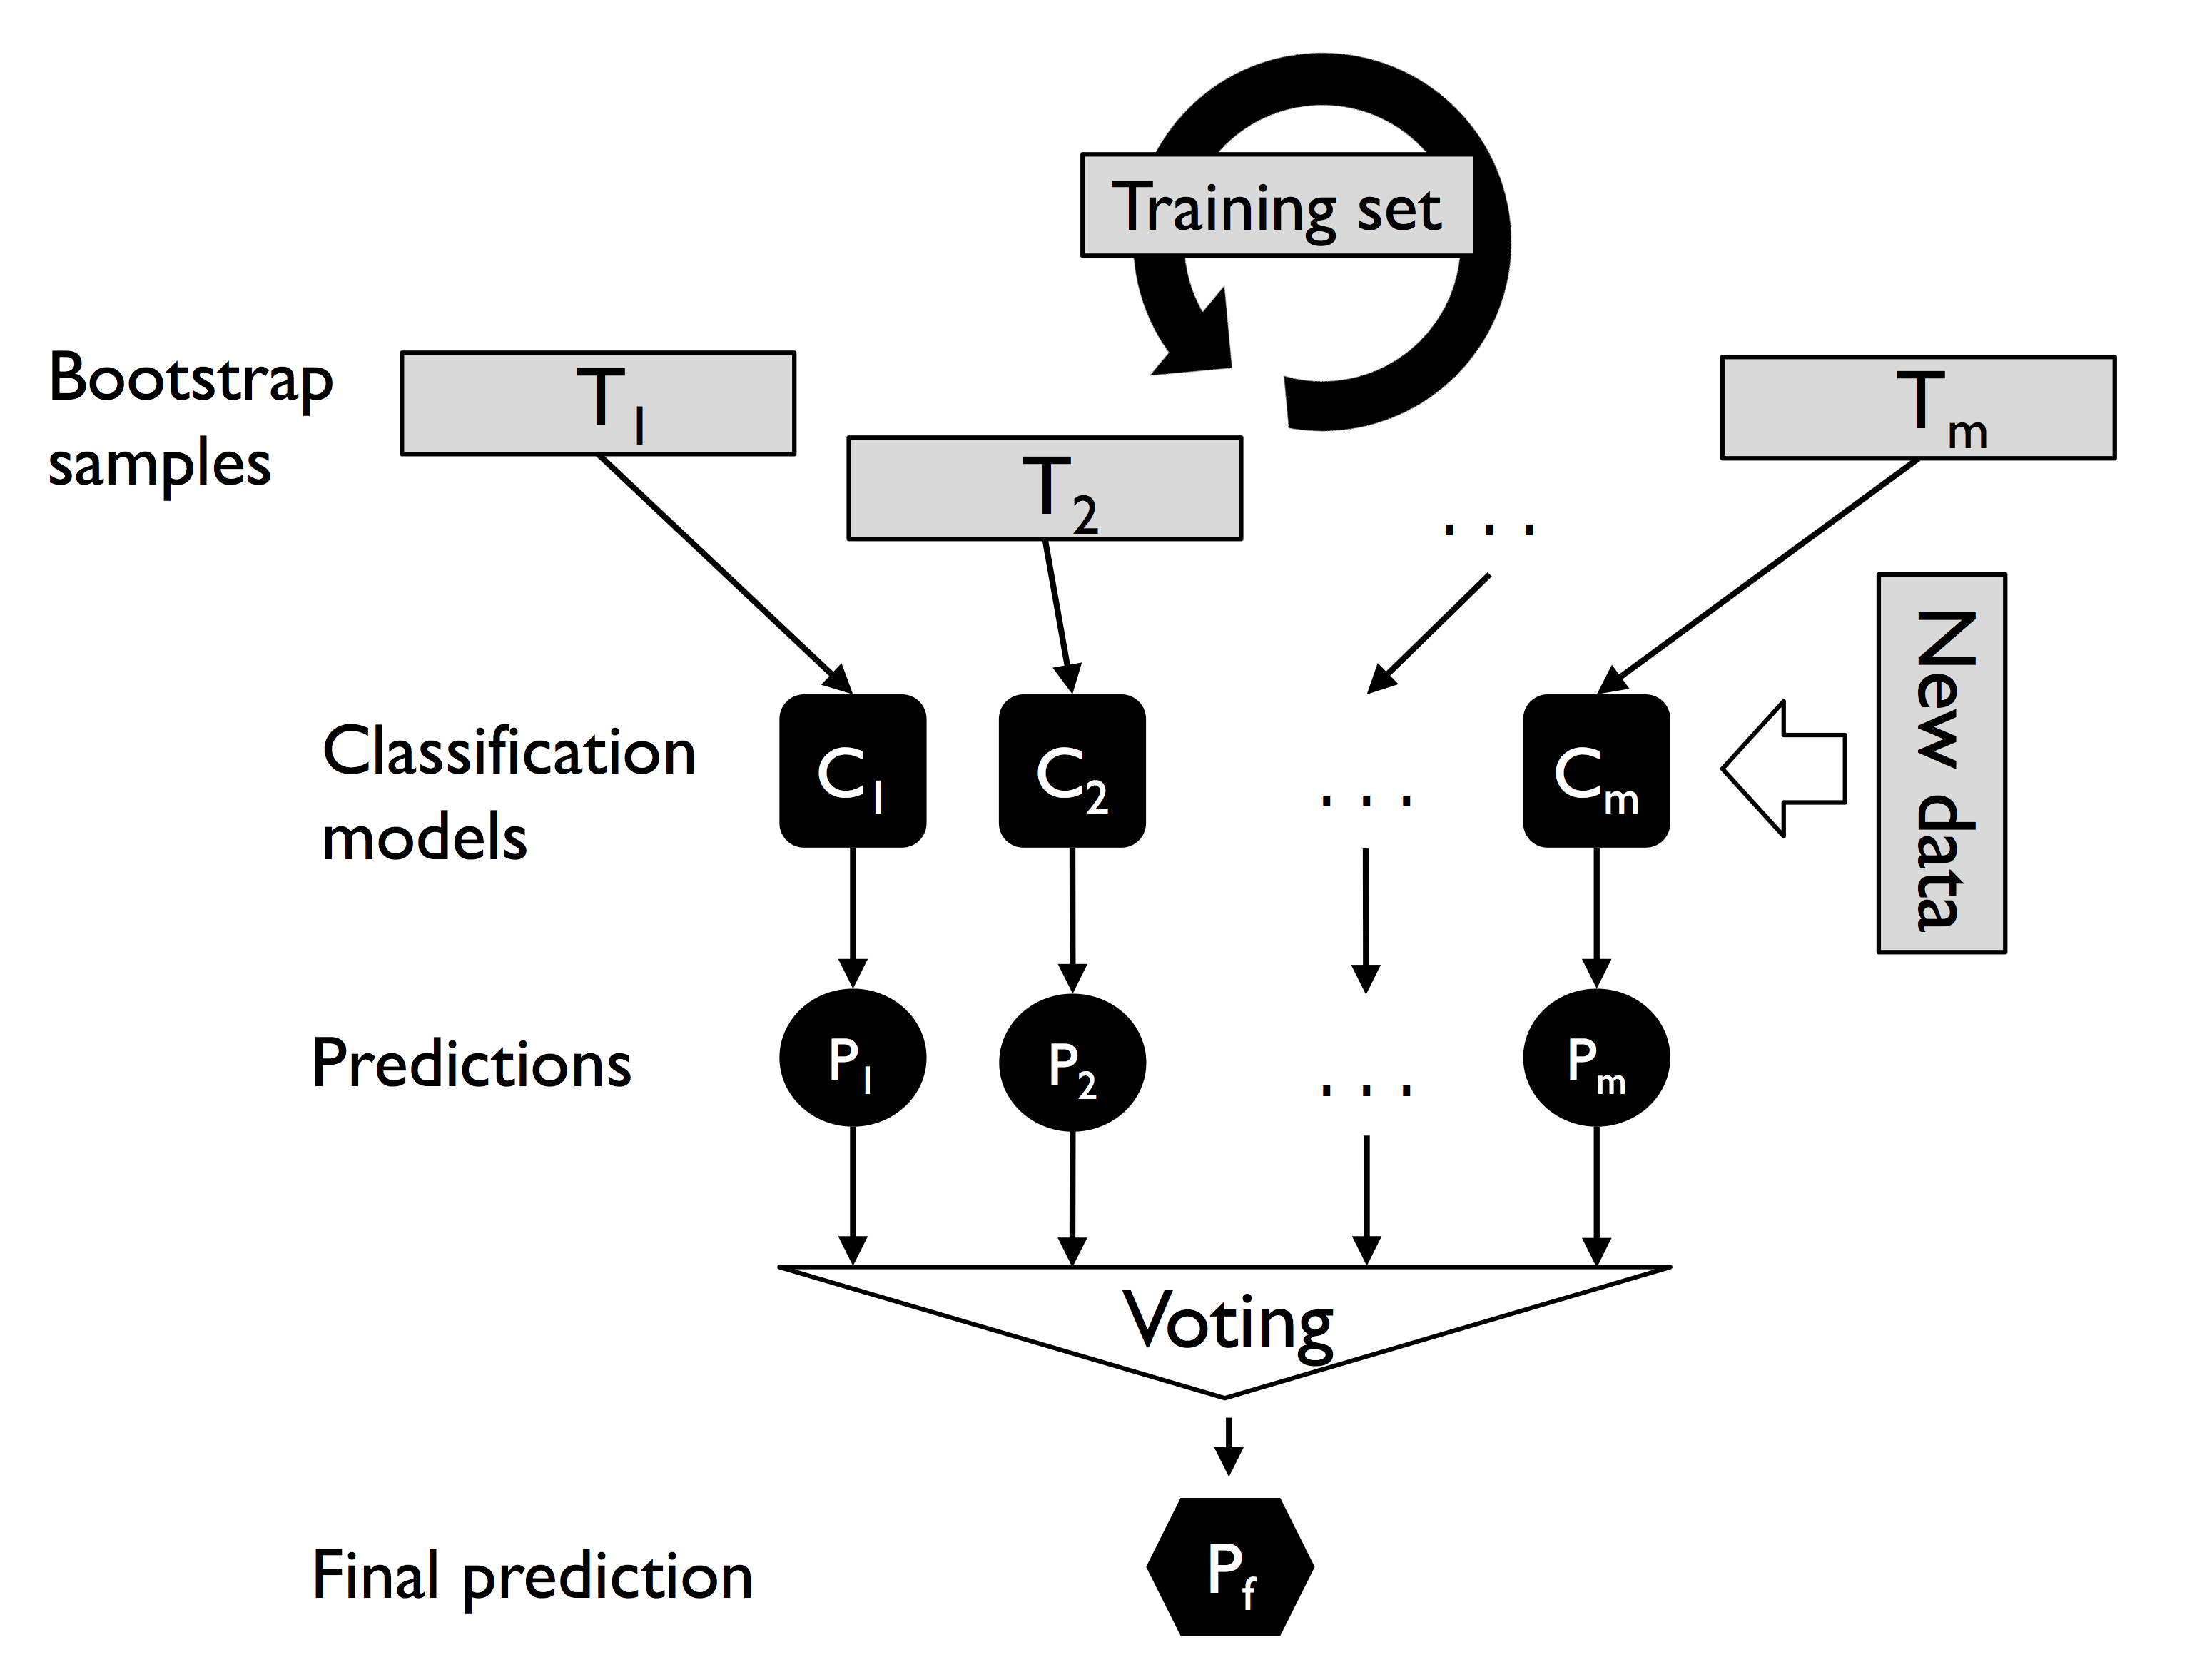

In [34]:
Image(filename='./figures/07_06.png', width=500) 

## Bagging in a nutshell

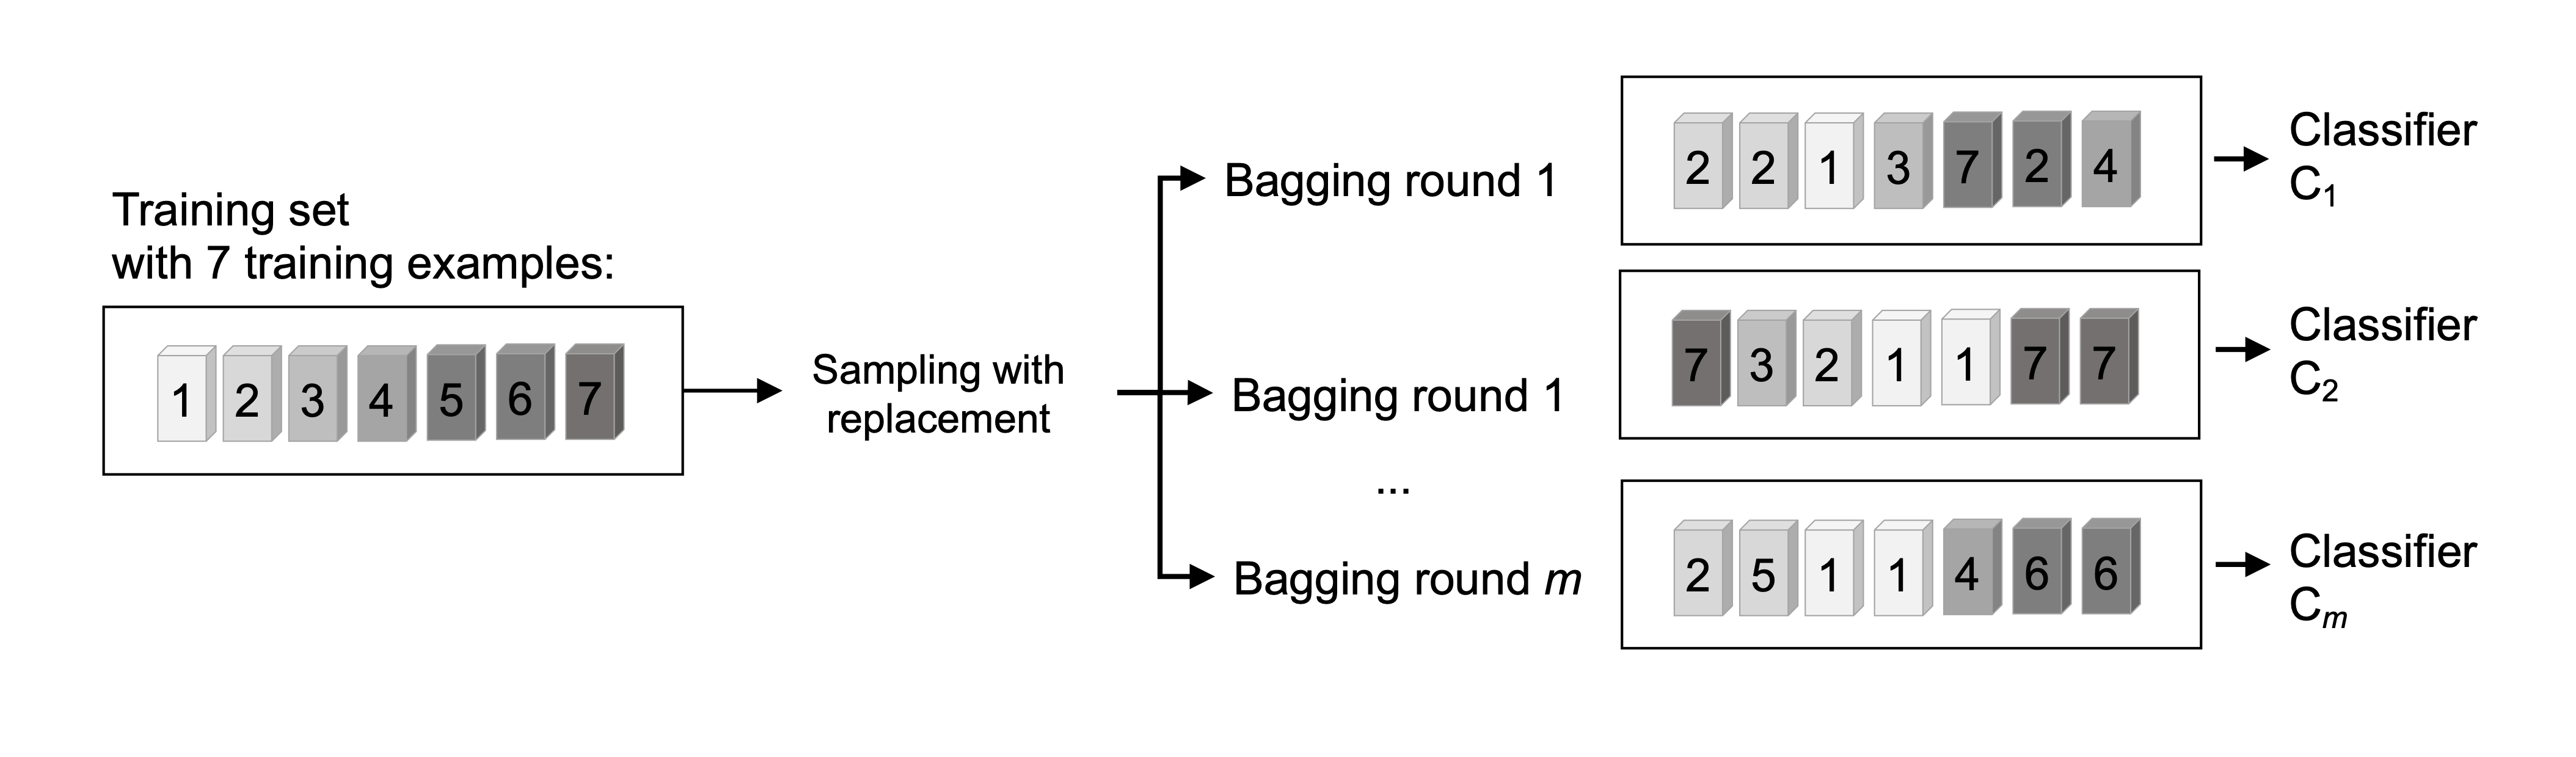

In [35]:
Image(filename='./figures/07_07.png', width=800) 

- As you can see from above each classifier receives a random subset of examples from the training dataset. 

- We denote these random samples obtained via bagging as Bagging round 1, Bagging round 2, and so on. 

- Each subset contains a certain portion of duplicates and some of the original examples don’t appear in a resampled dataset at all due to sampling with replacement. 

- Once the individual classifiers are fit to the bootstrap samples, the predictions are combined using majority voting.

![](2022-10-15-13-03-14.png)

> Bagging, also known as bootstrap aggregating, is the process in which multiple models **of the same learning algorithm are trained with bootstrapped samples of the original dataset**. Then, like the random forest example above, a vote is taken on all of the models’ outputs.

## Applying bagging to classify examples in the Wine dataset

In [36]:
import pandas as pd


df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

# if the Wine dataset is temporarily unavailable from the
# UCI machine learning repository, un-comment the following line
# of code to load the dataset from a local path:

# df_wine = pd.read_csv('wine.data', header=None)


In [37]:
df_wine

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


How many unique class we have?

In [38]:
df_wine["Class label"].unique()

array([1, 2, 3])

In [39]:
set(df_wine["Class label"])

{1, 2, 3}

Let us drop one class and do binary classification

In [40]:
# drop 1 class
df_wine = df_wine[df_wine['Class label'] != 1]

df_wine

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
59,2,12.37,0.94,1.36,10.6,88,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520
60,2,12.33,1.10,2.28,16.0,101,2.05,1.09,0.63,0.41,3.27,1.25,1.67,680
61,2,12.64,1.36,2.02,16.8,100,2.02,1.41,0.53,0.62,5.75,0.98,1.59,450
62,2,13.67,1.25,1.92,18.0,94,2.10,1.79,0.32,0.73,3.80,1.23,2.46,630
63,2,12.37,1.13,2.16,19.0,87,3.50,3.10,0.19,1.87,4.45,1.22,2.87,420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


In [41]:
y = df_wine['Class label'].values

In [42]:
list(set(y))

[2, 3]

In [43]:
X = df_wine[['Alcohol', 'OD280/OD315 of diluted wines']].values
X

array([[12.37,  1.82],
       [12.33,  1.67],
       [12.64,  1.59],
       [13.67,  2.46],
       [12.37,  2.87],
       [12.17,  2.23],
       [12.37,  2.3 ],
       [13.11,  3.18],
       [12.37,  3.48],
       [13.34,  1.93],
       [12.21,  3.07],
       [12.29,  1.82],
       [13.86,  3.16],
       [13.49,  2.78],
       [12.99,  3.5 ],
       [11.96,  3.13],
       [11.66,  2.14],
       [13.03,  2.48],
       [11.84,  2.52],
       [12.33,  2.31],
       [12.7 ,  3.13],
       [12.  ,  3.12],
       [12.72,  3.14],
       [12.08,  2.72],
       [13.05,  2.01],
       [11.84,  3.08],
       [12.67,  3.16],
       [12.16,  2.26],
       [11.65,  3.21],
       [11.64,  2.75],
       [12.08,  3.21],
       [12.08,  2.27],
       [12.  ,  2.65],
       [12.69,  2.06],
       [12.29,  3.3 ],
       [11.62,  2.96],
       [12.47,  2.63],
       [11.81,  2.26],
       [12.29,  2.74],
       [12.37,  2.77],
       [12.29,  2.83],
       [12.08,  2.96],
       [12.6 ,  2.77],
       [12.

We will encode the class labels into binary format and split the dataset into 80 percent training and 20 percent test datasets:

In [44]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1,
                             stratify=y)

- A BaggingClassifier algorithm is already implemented in scikit-learn, which we can import from the ensemble submodule.

- We will use an unpruned decision tree as the base classifier and create an ensemble of 500 decision trees fit on different bootstrap samples of the training dataset

In [45]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

#decision tree
tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=None, # unprunned
                              random_state=1)
# bagging
bag = BaggingClassifier(base_estimator=tree,
                        n_estimators=500, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        bootstrap_features=False, 
                        n_jobs=1, 
                        random_state=1)

#https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html

we will calculate the accuracy score of the prediction on the training and test datasets to compare the performance of the bagging classifier to the performance of a single unpruned decision tree:

In [46]:
from sklearn.metrics import accuracy_score


tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
      f'{tree_train:.3f}/{tree_test:.3f}')

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print(f'Bagging train/test accuracies '
      f'{bag_train:.3f}/{bag_test:.3f}')

Decision tree train/test accuracies 1.000/0.833
Bagging train/test accuracies 1.000/0.917


> Based on the accuracy values that we printed here, the unpruned decision tree predicts all the class labels of the training examples correctly; however, the substantially lower test accuracy indicates high variance (overfitting) of the model

> Although the training accuracies of the decision tree and bagging classifier are similar on the training dataset (both 100 percent), we can see that the bagging classifier has a slightly better generalization performance, as estimated on the test dataset.

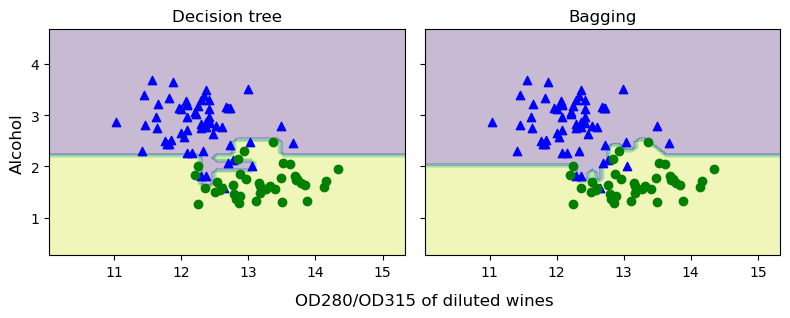

In [47]:
import numpy as np
import matplotlib.pyplot as plt


x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision tree', 'Bagging']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('figures/07_08.png', dpi=300, bbox_inches='tight')
plt.show()

As we can see in the resulting plot, the piece-wise linear decision boundary of the three-node deep decision tree looks smoother in the bagging ensemble

> We must note that the bagging algorithm can be an effective approach to reducing the variance of a model. However, bagging is ineffective in reducing model bias, that is, models that are too simple to capture the trends in the data well. This is why we want to perform bagging on an ensemble of classifiers with low bias, for example, unpruned decision trees.

![](2022-10-15-13-03-14.png)

![](2022-10-01-12-34-17.png)

# Boosting 

- Boosting is another ensemble learning technique that is closely related to bagging.

- In contrast to bagging, boosting creates an ensemble of classifiers that are trained sequentially, where each subsequent classifier attempts to correct the errors of its predecessor.

- The first classifier is trained on the original training dataset, and subsequent classifiers are trained on modified versions of the training dataset.

-  The modifications are based on the misclassifications of the previous classifier.

-  The misclassified training examples are assigned higher weights, so that subsequent classifiers focus more on the difficult examples.

-  The final prediction is calculated as a weighted majority vote of the individual predictions.

-  The most popular boosting algorithm is AdaBoost, which stands for Adaptive Boosting.
  

![](2022-10-15-13-07-01.png)

> The key concept behind boosting is to focus on training examples that are hard to classify, that is, to let the weak learners subsequently learn from misclassified training examples to improve the performance of the ensemble.

### Different Boosting Algorithms


The term 'Boosting' refers to a family of algorithms which converts a weak learner to a strong learner and  in general decreases the bias error and builds strong predictive models.

- AdaBoost: Short for Adaptive Boosting, AdaBoost

- Gradient Boosting Machine

  - XGBoost: Short for eXtreme Gradient Boosting, XGBoost is a popular implementation of gradient boosting machine

  - LightGBM: Short for Light Gradient Boosting Machine, LightGBM is a popular implementation of gradient boosting machine

  - catBoost: Short for categorical Boosting, catBoost is a popular implementation of gradient boosting machine

## Bagging vs Boosting

- In boosting the learners are trained sequentially

![](2022-10-22-11-16-24.png)

## How Adaptive boosting works

- with a special focus on its most common implementation: Adaptive Boosting (AdaBoost)

- In contrast to bagging, the initial formulation of the boosting algorithm uses random subsets of training examples drawn from the training dataset without replacement; the original boosting procedure can be summarized in the following four key steps: 

![](2022-10-22-12-02-26.png)
![](2022-10-22-12-02-39.png)

![](2022-10-22-12-14-07.png)

## Applying AdaBoost using scikit-learn

let’s now train an AdaBoost ensemble classifier via scikit-learn. 

We will use the same Wine subset that we used in the previous section to train the bagging meta-classifier.

In [48]:
from sklearn.ensemble import AdaBoostClassifier

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500, 
                         learning_rate=0.1,
                         random_state=1)

In [49]:
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print(f'Decision tree train/test accuracies '
      f'{tree_train:.3f}/{tree_test:.3f}')

ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)

ada_train = accuracy_score(y_train, y_train_pred) 
ada_test = accuracy_score(y_test, y_test_pred) 
print(f'AdaBoost train/test accuracies '
      f'{ada_train:.3f}/{ada_test:.3f}')

Decision tree train/test accuracies 0.916/0.875
AdaBoost train/test accuracies 1.000/0.917


> As you can see, the decision tree stump seems to underfit the training data in contrast to the unpruned decision tree that we saw in the previous section:

> _But, we can see that the AdaBoost model predicts all class labels of the training dataset correctly and also shows a slightly improved test dataset performance compared to the decision tree stump_

> **Note: Boosting is especially useful in models that exhibit underfitting. These models are highly biased and have low variance

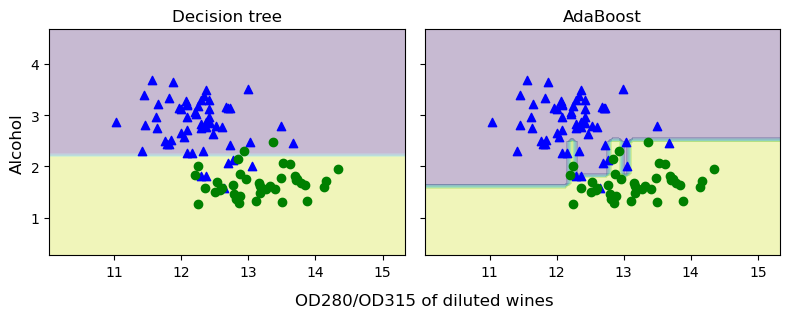

In [50]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))
f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))

for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision tree', 'AdaBoost']):
    clf.fit(X_train, y_train)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(X_train[y_train == 0, 0],
                       X_train[y_train == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(X_train[y_train == 1, 0],
                       X_train[y_train == 1, 1],
                       c='green', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)

plt.tight_layout()
plt.text(0, -0.2,
         s='OD280/OD315 of diluted wines',
         ha='center',
         va='center',
         fontsize=12,
         transform=axarr[1].transAxes)

#plt.savefig('figures/07_11.png', dpi=300, bbox_inches='tight')
plt.show()

> AdaBoost model is substantially more complex than the decision boundary of the decision stump. In addition, note that the AdaBoost model separates the feature space very similarly to the bagging classifier that we trained in the previous section as shown below.

- However, we must note that it is considered bad practice to select a model based on the repeated usage of the test dataset (as we did in Bagging). The estimate of the generalization performance may be overoptimistic.

![](2022-10-22-12-34-28.png)

# Gradient boosting -- training an ensemble based on loss gradients

- Gradient boosting is another variant of the boosting concept, that is, successively training weak learners to create a strong ensemble. 

- The key difference between AdaBoost and gradient boosting is that the latter uses loss gradients to update the ensemble of weak learners.
    
- Gradient boosting is the basis of popular machine learning algorithms such as XGBoost, which is well-known for winning Kaggle competitions.

- In this section, we will discuss the gradient boosting algorithm in more detail and implement it from scratch using NumPy. 


> The most popular implementation of gradient boosting is the Gradient Boosting Machine (GBM), which is a generalization of AdaBoost.
    

![](2022-10-19-14-51-11.png)

![](2022-10-19-15-00-05.png)


## Comparing AdaBoost with gradient boosting

- Fundamentally, gradient boosting is very similar to AdaBoost, which we discussed previously in this chapter. 

- AdaBoost trains decision tree stumps based on errors of the previous decision tree stump. 

- In particular, the errors are used to compute sample weights in each round as well as for computing a classifier weight for each decision tree stump when combining the individual stumps into an ensemble. 

- We stop training once a maximum number of iterations (decision tree stumps) is reached. 

- Like AdaBoost, gradient boosting fits decision trees in an iterative fashion using prediction errors.

## Using XGboost 

- In scikit-learn, gradient boosting is implemented as sklearn.ensemble.GradientBoostingClassifier (see https://scikit-learn.org/stable/modules/generated/sklearn.ensemble. GradientBoostingClassifier.html for more details). 

- Gradient boosting is a sequential process that can be slow to train. 

- More popular implementation of gradient boosting has emerged, namely, XGBoost.

> XGBoost proposed several tricks and approximations that speed up the training process substantially. Hence, the name XGBoost, which stands for **extreme gradient boosting**. XGBoost gained popularity as it has been the winning solution for many Kaggle competitions.

> Next to XGBoost, there are also other popular implementations of gradient boosting, for example, **LightGBM** and **CatBoost**. 

- Inspired by LightGBM, scikit-learn now also implements a HistGradientBoostingClassifier, which is more performant than the original gradient boosting classifier (GradientBoostingClassifier).

You can find more details about these methods via the resources below: 

• XGBoost: https://xgboost.readthedocs.io/en/stable/ 

•  LightGBM: https://lightgbm.readthedocs.io/en/latest/ 

• CatBoost: https://catboost.ai 

• HistGradientBoostingClassifier: https://scikit-learn.org/stable/modules/generated/ sklearn.ensemble.HistGradientBoostingClassifier.html However, since XGBoost is still among the most popular gradient boosting imp

In [55]:
#pip install XGBoost==1.5.0
import xgboost as xgb

In [53]:
xgb.__version__

'1.5.0'

Training XGboost

Fortunately, XGBoost’s XGBClassifier follows the scikit-learn API. So, using it is relatively straightforward: >>> imp

In [54]:
model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.01, max_depth=4, random_state=1, use_label_encoder=False)


gbm = model.fit(X_train, y_train)

y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

gbm_train = accuracy_score(y_train, y_train_pred) 
gbm_test = accuracy_score(y_test, y_test_pred) 
print(f'XGboost train/test accuracies '
      f'{gbm_train:.3f}/{gbm_test:.3f}')

[13:17:14] WARNING: /private/var/folders/1h/b7ng0kgj3w78mg7n8k7q7rch0000gn/T/pip-install-qk87lvle/xgboost_5500a79f36d74519b30d518370fca8b5/build/temp.macosx-11.0-arm64-cpython-39/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGboost train/test accuracies 0.968/0.917


- We fit the gradient boosting classifier with 1,000 trees (rounds) and a learning rate of 0.01. Typically, a learning rate between 0.01 and 0.1 is recommended.

- Next, we have the max_depth for the individual decision trees, which we set to 4. Since we are still boosting weak learners, a value between 2 and 6 is reasonable, but larger values may also work well depending on the dataset.

- Finally, use_label_encoder=False disables a warning message which informs users that XGBoost is not converting labels by default anymore, and it expects users to provide labels in an integer format starting with label 0.


Practice

- XGboost ( House Prices Prediction) : https://www.kaggle.com/code/dansbecker/xgboost
  
- XGboost : Sloan Digital Sky Survey Classification : https://www.kaggle.com/code/lucidlenn/data-analysis-and-classification-using-xgboost

- XGBoost (Titanic): https://www.kaggle.com/code/cbrogan/xgboost-example-python

- XGboost [Tutorial] Time Series forecasting with XGBoost : https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost


XGBoost, LighGbm, XgBoost

- https://www.kaggle.com/code/paulrohan2020/tutorial-lightgbm-xgboost-catboost-top-11/notebook
  

<br>
<br>

# Summary

...

---

Readers may ignore the next cell.

In [ ]:
! python ../.convert_notebook_to_script.py --input ch07.ipynb --output ch07.py

python: can't open file '/Users/shmuhammad/Document/VSCode/bookclub/ml-with-pytorch-sklearn/chapters/ch07/../.convert_notebook_to_script.py': [Errno 2] No such file or directory
